# Tokenizacja, segmentacja i lematyzacja tekstu

<br/>

## dr inż. Aleksander Smywiński-Pohl

## apohllo@agh.edu.pl

## http://apohllo.pl/dydaktyka/nlp

# Plan

* **tokenizacja i subtokenizacja**
* podział na zdania
* stemming i lematyzacja

<center>
    <img src="img/tokenization.jpeg" /><br/>
    <small>https://medium.com/data-science-in-your-pocket/tokenization-algorithms-in-natural-language-processing-nlp-1fceab8454af</small>
</center>

# Podział tekstu na wyrazy (tokenizacja)

* klasyfikacja tekstu $\rightarrow$ wyrazy = składowe wektora
* wyszukiwanie pełnotekstowe $\rightarrow$ wyrazy są kluczami odwrotnego indeksu
* tłumaczenie maszynowe $\rightarrow$ odnalezienie wyrazu w słowniku
* wykrywanie słów kluczowych $\rightarrow$ obliczanie statystyki dla wyrazów
* odpowiadanie na pytania $\rightarrow$ odpowiedź stanowi pewien zakres wyrazów
* itd.

https://regex101.com/r/pTEWml/3/

* istnieją problemy i algorytmy, w których nie trzeba dokonywać tokenizacji

## Kwestie problematyczne

* podział wyrażeń wielosegmentowych: `Bielsko-Biała`

* wyrażenia z apostrofem: `McDonald's`

* liczby: `100 000 000`, `20%`

* adresy url i e-mail: `http://www.agh.edu.pl`, `apohllo@agh.edu.pl`

* grupowanie znaków przestankowych, np. `...`

* agultynanty w j. polskim: <br/> *Ale mnie przestraszył**eś**.* <br/> *Al**eś** mnie przestraszył.*

* wyrazy, których nie ma w słowniku: <br/>
  *lockdown**u**&nbsp;*

## Rodzaje tokenizacji

*podział na zdania* (inaczej segmentacja) - atomem tekstu jest całe zdanie:
- `A transformer is a Deep Learning architecture based on the attention mechanism. It has no recurrent units.`
- `A transformer is a Deep Learning architecture based on the attention mechanism.` | `It has no recurrent units.`

*słowa* - każde słowo i inny "podobny" ciąg znaków traktowany jest atom:
- `Transformer's performance excels in natural language processing (NLP).`
- `Transformer's` | `performance` | `excels` | `in` | `natural` | `language` | `processing` | `(NLP).`

*znaki (lub bajty)* - każdy znak (lub bajt) traktowany jest jako atom:
- `Transformer's performance excels in natural language processing (NLP).`
- `T` | `r` | `a` | `n` | `s` | `f` **...**


*subtokenizacja* - słowa mogą być podzielone na mniejsze części, zależy to od modelu i języka:
- `Transformer's performance excels in natural language processing (NLP).`
- `transform` | `##er` | `'` | `s` | `performance` | `excel` | `##s` | `in` | `natural` | `language` | `processing` | `(` | `nl` | `##p` | `)` | `.`


## Unsupervised sentiment neuron - OpenAI

&nbsp;    
<center>
<div>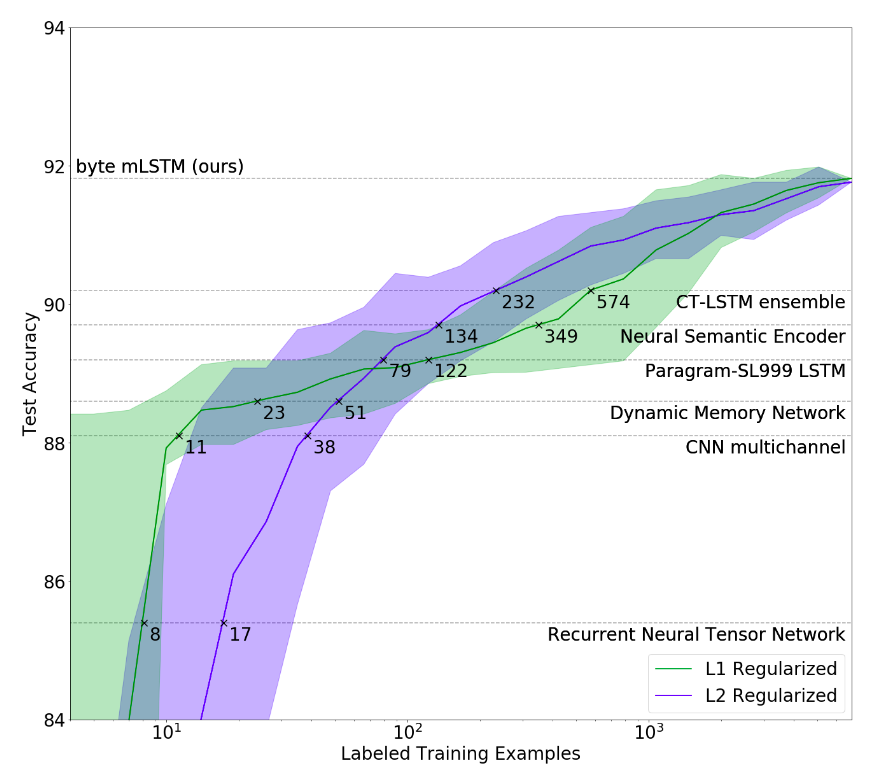</div>
</center>

<small>2017, https://openai.com/research/unsupervised-sentiment-neuron</small>

## SpaCy

In [6]:
#!python3 -m spacy download pl_core_news_sm

import spacy
import pandas as pd

nlp = spacy.load("pl_core_news_sm")
pl_example = "Ala mieszka w Bielsku-Białej, chodzi do McDonald's, zarabia 10 000 PLN a jej e-mail to ala@makota.pl"
doc = nlp(pl_example, disable=["tagger"])

for word in doc:
    print(word, end="/"),

Ala/mieszka/w/Bielsku/-/Białej/,/chodzi/do/McDonald's/,/zarabia/10/000/PLN/a/jej/e/-/mail/to/ala@makota.pl/

## Wyszukiwanie pełnotekstowe a tokenizacja

* ElasticSearch, SOLR - *silniki wyszukiwania pełnotekstowego*
* tokenizacja - podział dokumentów oraz zapytań na atomowe jednostki (*tokeny*)
* odwrotny indeks - kluczami są tokeny

<br/>
<br/>
<br/>

| `token` | `doc_1` | `doc_2` | `doc_3` |
|:--------|:-------:|:-------:|:-------:|
| zażółć  | x       |         |         |
| gęślą   | x       |         | x       |
| jaźń    | x       | x       | x       |


<center>
    <img src="img/fts-pipeline.drawio.png" />
    </center>

## Elastic Search - dostępne tokenizery

* **Standard Tokenizer** <br/> The standard tokenizer divides text into terms on word boundaries, as defined by the Unicode Text Segmentation algorithm. It removes most punctuation symbols. It is the best choice for most languages. <br/>
https://www.unicode.org/reports/tr29/

* **Letter Tokenizer** <br/> The letter tokenizer divides text into terms whenever it encounters a character which is not a letter.

* **Lowercase Tokenizer** <br/> The lowercase tokenizer, like the letter tokenizer, divides text into terms whenever it encounters a character which is not a letter, but it also lowercases all terms.

* **Whitespace Tokenizer** <br/> The whitespace tokenizer divides text into terms whenever it encounters any whitespace character.

* **UAX URL Email Tokenizer** <br/> The uax_url_email tokenizer is like the standard tokenizer except that it recognises URLs and email addresses as single tokens.

Źródło https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-tokenizers.html

# Subtokenizacja

❓ Dlaczego tokenizacja względem wyrazów nie wystarcza?

* problemem jest  **rozmiar słownika**
* całkowita liczba unikalnych słów występujących co najmnie 3 razy w angielskiej Wikipedii: 2 747 823
* źródło: https://github.com/IlyaSemenov/wikipedia-word-frequency

In [13]:
gpt2_enc = tiktoken.get_encoding("gpt2")
gpt2_enc.n_vocab

50257

## BPE, Word piece, Sentence piece - tokenizacja na potrzeby MT

* skutkiem tłumaczenia maszynowego może być zmiana liczby tokenów <br/>
  

* subtokenizacja - słowa dzielone są na mniejsze elementy

* popularne algorytmy:
  * BPE, Word piece - wstępny podział na tokeny, np. standardowymi tokenizerami, następnie subtokenizacja
  * sentence piece - traktuje spację jak zwykły znak

### BPE

1. buduje słownik częstości wystąpień liter (uwzględniając specjalny znak końca słowa `</w>`)
2. wybiera parę łańcuchów (na początku liter), która występuje najczęściej
3. dodaje tę parę do słownika
4. wraca do punktu 2 - aż osiągnie zadany rozmiar słownika

In [3]:
import re , collections

def get_stats(vocab):
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i] , symbols[i + 1]] += freq
    return pairs

def merge_vocab(pair, vin) :
    vout = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in vin:
        wout = p.sub(''.join(pair), word)
        vout[wout] = vin[word]
    return vout

vocab = { 'l o w </w>' : 5 , 'l o w e s t </w>' : 2 , 
    'n e w e r </w>' : 6 , 'w i d e r </w>' : 3 , 'n e w </w>' : 2}
num_merges = 10
for i in range(num_merges):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)
    #print(best)
    
print(vocab)

{'low</w>': 5, 'low e s t </w>': 2, 'newer</w>': 6, 'wid er</w>': 3, 'new </w>': 2}


### word piece

1. podobny do BPE, ale specjalny znak jest na początku, a nie końcu
2. wybierając parę, nie kieruje się częstością, ale maksymalizacją prawdopodobieństwa modelu językowego

### sentence piece

1. podobny do poprzenich
1. najważniejsza różnica, to brak wstępnej tokenizacji tekstu - działa lepiej np. dla chińskiego i japońskiego

In [11]:
from tokviz.visualization import get_token_colors, visualize_tokens
from IPython.display import display
from IPython.core.display import HTML

def visualize_from_tokens(text: str, tokens: list[str]):
    """Display tokens in colors."""
    token_colors = get_token_colors(tokens)
    
    num_tokens = len(tokens)
    num_chars = len(text)
    
    display(HTML(f"<p><b>Number of Tokens:</b> {num_tokens}</p>"))
    display(HTML(f"<p><b>Number of Characters:</b> {num_chars}</p>"))
    
    visualize_tokens(tokens, token_colors)

In [12]:
import tiktoken

def tiktoken_tokenize(text: str, enc: tiktoken.core.Encoding) -> list[str]:
    encoded_tokens = enc.encode(text)
    return [enc.decode([token]) for token in encoded_tokens]

In [27]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

visualize_from_tokens(en_example, tiktoken_tokenize(en_example, tokenizer))

In [19]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

en_example = """
New York. Limited time offer. This is an offer for a Basic Digital Access Subscription. Your payment method will automatically be charged in advance every four weeks. You will be charged the introductory offer rate every four weeks for the introductory period of one year, and thereafter will be charged the standard rate every four weeks until you cancel. Your subscription will continue until you cancel. You can cancel anytime.
"""

visualize_from_tokens(en_example, tiktoken_tokenize(en_example, tokenizer))

In [20]:
pl_example = """Ala mieszka w Bielsku-Białej, chodzi do McDonald's, zarabia 10 000 PLN, jej e-mail to ala@makota.pl.
Alicja nie boi się lockdownu i odwiedza New York.
"""

visualize_from_tokens(pl_example, tiktoken_tokenize(pl_example, tokenizer))

In [21]:
hard_example = """Konstantynopolitańczykiewiczówna"""

visualize_from_tokens(hard_example, tiktoken_tokenize(hard_example, tokenizer))

In [22]:
# Polish Bert też używa word piece
tokenizer = BertTokenizer.from_pretrained('dkleczek/bert-base-polish-cased-v1')

visualize_from_tokens(pl_example, tiktoken_tokenize(pl_example, tokenizer))

In [23]:
hard_example = """Konstantynopolitańczykiewiczówna"""

visualize_from_tokens(hard_example, tiktoken_tokenize(hard_example, tokenizer))

In [26]:
# XLNET używa sentence piece, trenowany był na danych dla j. angielskiego
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlnet-base-cased')

visualize_from_tokens(pl_example, tiktoken_tokenize(pl_example, tokenizer))

# Potok przetwarzania w modelach neuronalnych

&nbsp;    
<center>
<div>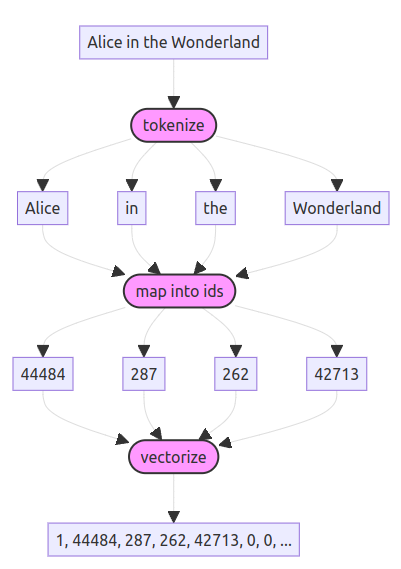</div>
</center>


# Plan

* tokenizacja i subtokenizacja
* **podział na zdania**
* stemming i lematyzacja

# Podział tekstu na zdania

* modelowanie języka wymaga wskazania początku i końca zdania
* parsing realizowany jest dla pojedynczych zdań
* streszczanie może ograniczać się do wyboru podzbioru zdań z tekstu
* automatyczna korekta tekstu wymaga podziału na zdania
* nowelizacja aktów prawnych może np. mówić o pierwszym zdaniu jakiegoś artykułu

https://regex101.com/r/pTEWml/5/
https://regex101.com/r/VIfXUH/1

## SRX - dopasowanie regułowe

```
<rule break="no">
    <beforebreak>\b[Zz]ob\.\s</beforebreak>
    <afterbreak></afterbreak>
</rule>
<rule break="yes">
    <beforebreak>[^\s]\.pl\.\s</beforebreak>
    <afterbreak>\p{Lu}\p{Ll}+</afterbreak>
</rule>
```

In [7]:
import spacy
from spacy.lang.pl import Polish

#nlp = Polish()
nlp = spacy.load("pl_core_news_sm")
nlp.add_pipe("sentencizer")
doc = nlp("""
Wyrokiem łącznym z dnia 8 marca 2013 roku, wydanym w sprawach z powództw P. S. i J. S. przeciwko (...) S.A. w W. o zadośćuczynienie, Sąd Okręgowy w Sieradzu zasądził od pozwanego na rzecz powoda P. S. kwotę 20.000 złotych wraz z ustawowymi odsetkami od dnia 23 maja 2012 roku do dnia zapłaty (pkt.1), oddalił powództwo P. S. w pozostałej części (pkt.2), zasądził od pozwanego na rzecz powoda J. S. kwotę 20.000 złotych wraz z ustawowymi odsetkami od dnia 23 maja 2012 roku do dnia zapłaty (pkt.3), oddalił powództwo J. S. w pozostałej części (pkt.4); nakazał pobrać od pozwanego (...) S.A. w W. na rzecz Skarbu Państwa - Sądu Okręgowego w Sieradzu kwotę 2.040 złotych tytułem brakujących części opłat sądowych od roszczeń obu powodów oraz kwotę 71 złotych jako część wydatków poniesionych w toku procesu tymczasowo z funduszy Skarbu Państwa (pkt.5) i nie obciążył powodów kosztami procesu (pkt.6).
""")
for sent in doc.sents:
    print(sent.text)
    print("---")



---
Wyrokiem łącznym z dnia 8 marca 2013 roku, wydanym w sprawach z powództw P. S. i J. S. przeciwko (...) S.A. w W. o zadośćuczynienie,
---
Sąd Okręgowy w Sieradzu zasądził od pozwanego na rzecz powoda P. S. kwotę 20.000 złotych wraz z ustawowymi odsetkami od dnia 23 maja 2012 roku do dnia zapłaty (pkt.1), oddalił powództwo P. S. w pozostałej części (pkt.2), zasądził od pozwanego na rzecz powoda J. S. kwotę 20.000 złotych wraz z ustawowymi odsetkami od dnia 23 maja 2012 roku do dnia zapłaty (pkt.3), oddalił powództwo J. S. w pozostałej części (pkt.4); nakazał pobrać od pozwanego (...) S.A. w W. na rzecz Skarbu Państwa - Sądu Okręgowego w Sieradzu kwotę 2.040 złotych tytułem brakujących części opłat sądowych od roszczeń obu powodów oraz kwotę 71 złotych jako część wydatków poniesionych w toku procesu tymczasowo z funduszy Skarbu Państwa (pkt.5) i nie obciążył powodów kosztami procesu (pkt.6).

---


## Narzędzia do podziału na zdania

* LanguageTool, reguły SRX - https://github.com/languagetool-org/languagetool
* Alternatywna implementacja dla reguł SRX -  https://github.com/loomchild/segment 
* SpaCy https://spacy.io/usage/linguistic-features#sbd

# Plan

* tokenizacja i subtokenizacja
* podział na zdania
* **stemming i lematyzacja**

# Stemming i lematyzacja

* stemming - usunięcie odmiennej końcówki wyrazu
* lematyzacja - określenie formy podstawowej wyrazu

## Zastosowania

* budowanie indeksu wyszukiwania pełnotekstowego $\rightarrow$ uwzględnienie form 
  odmienionych w zapytaniu lub w tekście
* klasyfikacja tekstu $\rightarrow$ zmniejszenie wymiarowości wektorów
* wykrywanie słów kluczowych $\rightarrow$ wyrazy powinny być zlematyzowane
* ekstrakcja informacji $\rightarrow$ zlematyzowane wyrazy są bardziej czytelne

## Stemming (j. angielski)

```
This was not the map we found in Billy Bones’s chest, but
an accurate copy, complete in all things-names and heights
and soundings-with the single exception of the red crosses
and the written notes.
```

**Porter stemmer** (proste przekształcenia usuwające końcówki słów):

```
Thi wa not the map we found in Billi Bone s chest but an
accur copi complet in all thing name and height and sound
with the singl except of the red cross and the written note
```

In [ ]:
#!pip install pystempel 

from stempel import StempelStemmer
import re

stemmer = StempelStemmer.default()

string = """
Partia polityczna jest dobrowolną organizacją, występującą pod określoną 
nazwą, stawiającą sobie za cel udział w życiu publicznym poprzez wywieranie
metodami demokratycznymi wpływu na kształtowanie polityki państwa
lub sprawowanie władzy publicznej.
"""

for word in string.split(" "):
    word = re.sub(r'\W',' ', word.lower()).strip()
    print(stemmer.stem(word).lower(), end=" ")

## Stemming (j. polski)

```
Partia polityczna jest dobrowolną organizacją, występującą pod określoną 
nazwą, stawiającą sobie za cel udział w życiu publicznym poprzez wywieranie
metodami demokratycznymi wpływu na kształtowanie polityki państwa
lub sprawowanie władzy publicznej.
```

**pystempel**

```
partia polityczny jest dobrowolny organizacja występujący? pod określić? 
nazwać? stawiający? się? za cel udzieć! w żyć? publiczny poprzee! wywieranie?
metoda demokratyczny wpływ na kształtować polityka państwa?
lub sprawowani! władz? publiczny 
```

* stemmer działa deterministycznie i bezkontekstowo
* działanie stemmera jest szybkie, ponieważ jest oparty o automat skończony lub drzewo sufiksów
* wadą stemmera jest to, że może on popełniać błędy 2 typów:
  * błędna lematyzacja (utworzenie formy, która nie jest poprawna w danym kontekście)
  * błędny lemat (utworzenie formy, która nie istnieje w języku)

In [ ]:

#from stempel import StempelStemmer
from stempel import StempelStemmer
import re

stemmer = StempelStemmer.default()

strings = [
    "Lewandowski nie strzelił żadnych goli.",
    "Lewandowski goli się codziennie.",
    "Lewandowski i inni mężczyźni na plaży nudystów byli goli.",
    "pies psu psem"
]

for string in strings:
    for word in string.split(" "):
        word = re.sub(r'\W',' ', word.lower()).strip()
        print(stemmer.stem(word).lower(), end=" ")
    print("")

<center><img src="img/goli-m.png" /></center>

# Lematyzacja (j. polski)

```
Partia polityczna jest dobrowolną organizacją, występującą pod określoną 
nazwą, stawiającą sobie za cel udział w życiu publicznym poprzez wywieranie
metodami demokratycznymi wpływu na kształtowanie polityki państwa
lub sprawowanie władzy publicznej.
```

**KRNNT** (tagger i lematyzer)

```
partia polityczny być dobrowolny organizacja, występować pod określony
nazwa, stawiać siebie za cel udział w życie publiczny poprzez wywierać
metoda demokratyczny wpływ na kształtować polityka państwo 
lub sprawować władza publiczny.
```

* tagger przeprowadza pełną analizę morfosyntaktyczną zdania, wykorzystując kontekst
* wybierany jest lemat zgodny z opisem morfologicznym (może być wiele takich lematów)
* wybór jest niedeterministyczny (tzn. zależny od wyuczonego modelu)
* działanie taggera jest dużo wolniejsze

In [15]:
#! docker run -p 9003:9003 -it djstrong/krnnt:1.0.0
!curl -s -X POST "localhost:9003/?output_format=conll" -d "Lewandowski nie strzelił żadnych goli." | cut -f 2 | tr '\n' ' '
!echo
!curl -s -X POST "localhost:9003/?output_format=conll" -d "Lewandowski goli się codziennie." | cut -f 2  | tr '\n' ' '
!echo
!curl -s -X POST "localhost:9003/?output_format=conll" -d "Lewandowski i inni mężczyźni na plaży nudystów byli goli." | cut -f 2  | tr '\n' ' '

Lewandowski nie strzelić żaden gol .  
Lewandowski golić się codziennie .  
Lewandowski i inny mężczyzna na plaża nudysta być goły .  

In [18]:
import spacy
from spacy.lang.pl import Polish

#nlp = Polish()
nlp = spacy.load("pl_core_news_sm")
doc = nlp("""
Lewandowski nie strzelił żadnych goli. 
Lewandowski goli się codziennie. 
Lewandowski i inni mężczyźni na plaży nudystów byli goli.
""")
for token in doc:
    print(token.lemma_, end='/')


/Lewandowski/nie/strzelić/żaden/gol/./
/Lewandowski/golić/się/codziennie/./
/Lewandowski/i/inny/mężczyzna/na/plaża/nudysta/być/gol/./
/

# Combo

<img src="img/combo.png"/>

http://combo-demo.nlp.ipipan.waw.pl/combo-pl



## Lematyzacja cd.

* może być potraktowany jako problem tłumaczenia maszynowego
* zdanie z formami odmienionymi jest wtedy językiem "źródłowym", a zdanie zlematyzowane jest językiem "docelowym"
* lematyzacja taka może działać kontekstowo i bezoktekstowo
* wyniki lematyzacji w oparciu o narzędzie architekturę transformacyjną: 93% (A. Warchoł - praca magisterska)
* zaletą podejścia jest uniezależnienie się od słownika morfosyntaktycznego

# Narzędzia

* SpaCy - jest moduł do lematyzacji j. polskiego
* Stempel - http://www.getopt.org/stempel/
* pystempel - `pip install pystempel`
* Morfologik - https://github.com/morfologik/morfologik-stemming
* Morfeusz - http://sgjp.pl/morfeusz/
* KRNNT - https://github.com/kwrobel-nlp/krnnt/
* Stanford NLP - https://stanfordnlp.github.io/stanfordnlp/installation_download.html
* COMBO - https://github.com/360er0/COMBO


# Literatura 

[Speech and Language Processing. Daniel Jurafsky & James H. Martin, chapter 2](https://web.stanford.edu/~jurafsky/slp3/2.pdf)